## Name: Debangshu Bhattacharya
## Roll: MDS201910

In [ ]:
#importing necessary libraries
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import pandas as pd
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
#reading previous preprocessed_corpus
wd = 'My Drive/NLP/'
with open(os.path.join(wd, 'preprocessed_corpus.txt'), 'r') as f:
  corpus = f.read()

## Step 1: Preprocessing

In previous preprocessing the steps taken were as follows:

1) Removed all non-english documents from corpus

2) Remove links from corpus

3) Remove parenthesis and all text in between parenthesis

4) Remove apostrophe and quote from text

5) Remove extra spaces from text

6) Correct sentence end structure (for example, replace dot space with dot and space dot with dot)

7) Separate sentences with sentence separator

8) Remove punctuations

Here, we have to remove the sentences separators first and each document will now be a sentence.

**The additional preprocessing steps that will be done here are as follows:**

**9) Removing stopword**

**10) Lemmatization**

In [ ]:
#Reading preprocessed corpus into a list of strings where each string represents one document
corpus2 = []
docs = corpus.split('\n')
n = len(docs)
print (n)
for i in tqdm(range(n)):
  doc = docs[i]
  sentences_doc = doc.split('$$$$$$$$')
  #first sentence start has $$$$ even after split. Removing that
  t = sentences_doc[0]
  sentences_doc[0] = t[4:]

  #last sentence end has $$$$. Removing that
  t = sentences_doc[-1]
  sentences_doc[-1] = t[:-4]
  
  doc2 = ' '.join(sentences_doc)
  corpus2.append(doc2)

  3%|▎         | 1637/54941 [00:00<00:03, 16369.12it/s]

54941


100%|██████████| 54941/54941 [00:03<00:00, 17327.89it/s]


In [ ]:
#deleting old preprocessed corpus from memory so that RAM does not overflow
del corpus

### Removing stopwords and Lemmatizing

In [ ]:
#set of stopwords from NLTK
stop_words = set(stopwords.words('english'))
len(stop_words)

179

In [ ]:
#loading WordNetLemmatizer from NLTK. By default, it will only lemmatize nouns. Here I am going over each word and removing it if it is a stopword. Else, I am adding the lemmatized word.
lemmatizer = WordNetLemmatizer()

new_preprocessed_corpus = []

for doc in tqdm(corpus2):
  words = word_tokenize(doc)
  non_stopwords = [word for word in words if word not in stop_words]
  non_stopwords_lemmatized = [lemmatizer.lemmatize(word) for word in non_stopwords]
  
  text = ' '.join(non_stopwords_lemmatized)
  new_preprocessed_corpus.append(text)

100%|██████████| 54941/54941 [24:57<00:00, 36.68it/s]


In [ ]:
len(new_preprocessed_corpus)

54941

In [ ]:
#writing the new corpus into a file
new_corpus = '\n'.join(new_preprocessed_corpus)
with open(os.path.join(wd,'new_preprocessed_corpus.txt'),'w') as f:
  f.write(new_corpus)

## Step 2: Build Word Vectors

In [ ]:
#load necessary libraries to build word vectors
import gensim
from gensim.models import word2vec
import logging


In [ ]:
wd = 'My Drive/NLP/'

In [ ]:
#function to compute word vector given preprocessed corpus
def compute_word_vectors(): 
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    text = word2vec.Text8Corpus(os.path.join(wd, 'new_preprocessed_corpus.txt'))
    model = word2vec.Word2Vec(text, size=128, window=5, min_count=50, workers=10, iter=10)
    model.save(os.path.join(wd, 'text8.model.bin'))
    return model

In [ ]:
#building model
model = compute_word_vectors()

2021-03-30 13:19:02,380 : INFO : collecting all words and their counts
2021-03-30 13:19:02,440 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-30 13:19:36,907 : INFO : PROGRESS: at sentence #10000, processed 100000000 words, keeping 1265382 word types
2021-03-30 13:19:46,448 : INFO : collected 1498212 word types from a corpus of 126961368 raw words and 12697 sentences
2021-03-30 13:19:46,450 : INFO : Loading a fresh vocabulary
2021-03-30 13:19:47,497 : INFO : effective_min_count=50 retains 59092 unique words (3% of original 1498212, drops 1439120)
2021-03-30 13:19:47,499 : INFO : effective_min_count=50 leaves 122265222 word corpus (96% of original 126961368, drops 4696146)
2021-03-30 13:19:47,708 : INFO : deleting the raw counts dictionary of 1498212 items
2021-03-30 13:19:47,771 : INFO : sample=0.001 downsamples 16 most-common words
2021-03-30 13:19:47,775 : INFO : downsampling leaves estimated 120455610 word corpus (98.5% of prior 122265222)
2021-03

## Step 3: Selection of keywords


In [ ]:
keywords = ['depression', 'immunity', 'epidemic' ,'suicide'	,'economy', 'bat', 'pollution', 'lockdown', 'healthcare' ,'twitter']


In [ ]:
# function to compute similar words 
def compute_similar_words(model,source_word, topn=5):
    print('\r Computing similar words for the source word - {0}'.format(source_word),end='')
    similar_words = [source_word]
    try:
        top_words = model.wv.most_similar(source_word,topn=topn)
        similar_words.extend([val[0] for val in top_words])
    except KeyError as err:
        print(err.args)
    return similar_words  

In [ ]:
#funcion to find similar words at 3 levels. I tried for similar words at 4 level deep but the graph is getting clumsy so I am keeping calculating similar words at level 3.
def find_similar_words():
    columns = ['word'+str(i-1) for i in range(1,7)]
    df = pd.DataFrame(data=None,columns=columns)

    #Keywords contains the list of keywords from the vocabulary. 
    #These keywords are used to find similar words 

    for source_word in keywords:
        similar_words = compute_similar_words(model,source_word)
        df.loc[len(df)] = similar_words
        
        for i in range(1,len(similar_words)):
            sec_similar_words = compute_similar_words(model,similar_words[i])
            df.loc[len(df)] = sec_similar_words

            for j in range(1, len(sec_similar_words)):
              third_similar_words = compute_similar_words(model, sec_similar_words[j])
              df.loc[len(df)] = third_similar_words


    #Save similar words to a file. This file will be used to build the graph
    #df.to_csv('../COVID19/results/similar_words_assignment3.csv')
    return df

In [ ]:
df = find_similar_words()

 Computing similar words for the source word - twitter

In [ ]:
df

,word0,word1,word2,word3,word4,word5
0,depression,insomnia,anxiety,suicidality,ptsd,psychopathology
1,insomnia,depression,anxiety,anxietydepression,depressive,somatization
2,depression,insomnia,anxiety,suicidality,ptsd,psychopathology
3,anxiety,depression,loneliness,worry,burnout,insomnia
4,anxietydepression,insomnia,depressive,depression,anxiety,somatization
...,...,...,...,...,...,...
305,facebook,instagram,twitter,telegram,linkedin,whatsapp
306,blog,youtube,facebook,reddit,twitter,instagram
307,youtube,instagram,facebook,blog,tiktok,reddit
308,instagram,facebook,twitter,youtube,reddit,tiktok


In [ ]:
df.to_csv(os.path.join(wd, 'similar_words.csv'))

### Step 4: Build Graph

In [ ]:
#color of each keyword
cmap_components = {'depression':'red', 
                    'immunity':'yellow',
                    'epidemic': 'gray',
                    'suicide' : 'royalblue',
                    'economy': 'lightsteelblue', 
                    'bat': 'brown', 
                    'pollution':'purple',
                    'lockdown': 'cyan', 
                    'healthcare' : 'green',
                    'twitter': 'pink'}

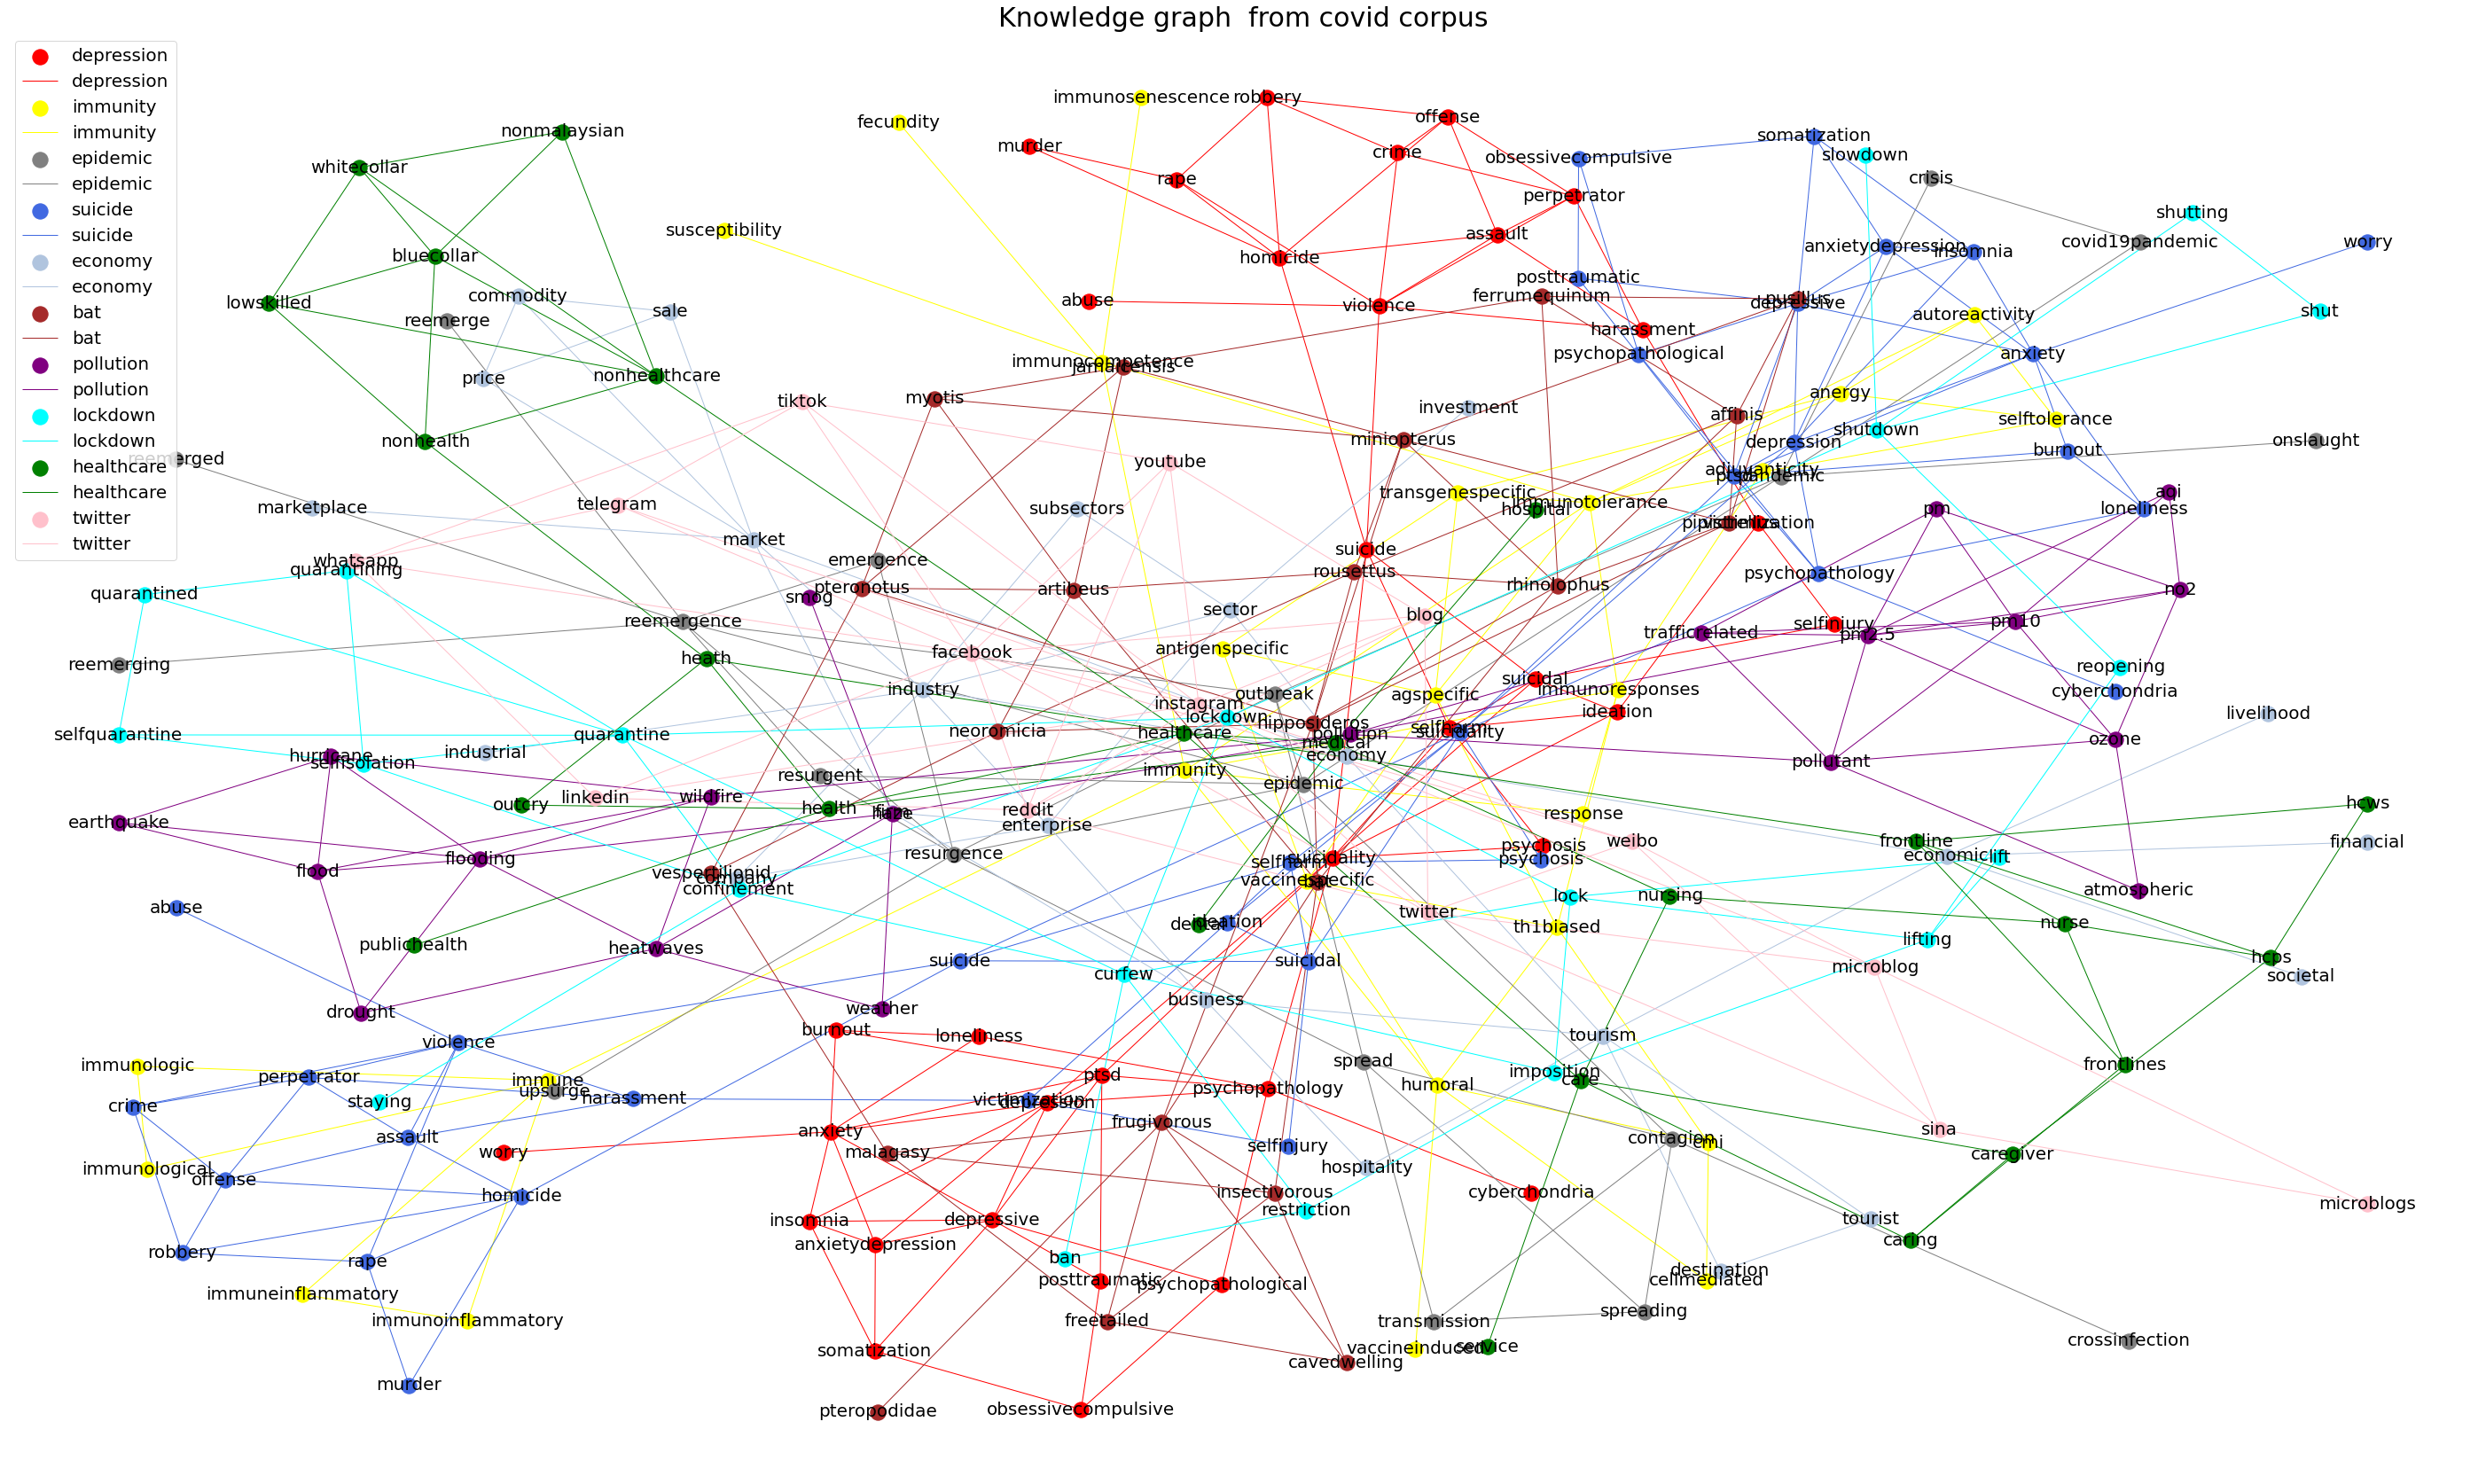

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

words = pd.read_csv(os.path.join(wd, 'similar_words.csv'))

g = nx.cubical_graph()

#Construct the graph
#for every source word(node), add edges - connected through similarity
#As there two levels of similar words, we need to repeat the same to construct the graph
for i, row in words.iterrows():
    for j in range(1,len(row)):
        g.add_node(row[j])
    for j in range(1,len(row)):
        g.add_edge(row[1], row[j])    
      
G = nx.petersen_graph()
plt.subplot()
options = {
    #'node_color': 'blue',
    #'node_size': 8,
    #'linewidths': 0.3,
    #'width': 0.5,
    'font_size':20,
}

fedges = filter(lambda x: g.degree()[x[0]] >= 3 and g.degree()[x[1]] >= 5, g.edges())
f = nx.Graph()                                                                                                                                     
f.add_edges_from(fedges)

#This is to show how well the keyword is connected with the other words in the corpus  
#change the keyword to obtain a different graph
#you do not need this while running the entire no

plt.rcParams['figure.figsize'] = [50,30]

for keyword in keywords:
  subgraph = nx.node_connected_component(f,keyword)
#print()
  nx.draw(g.subgraph(subgraph), with_labels=True,**options, edge_color = cmap_components[keyword], node_color = cmap_components[keyword], label = keyword)

plt.legend(loc = 'upper left', fontsize = 'medium', prop={'size': 20})
plt.title("Knowledge graph  from covid corpus", fontsize = 30)
plt.savefig(os.path.join(wd, 'knowledge_graph.pdf'))
plt.show()

### Showing each connected component of each keyword separately

### 1) depression

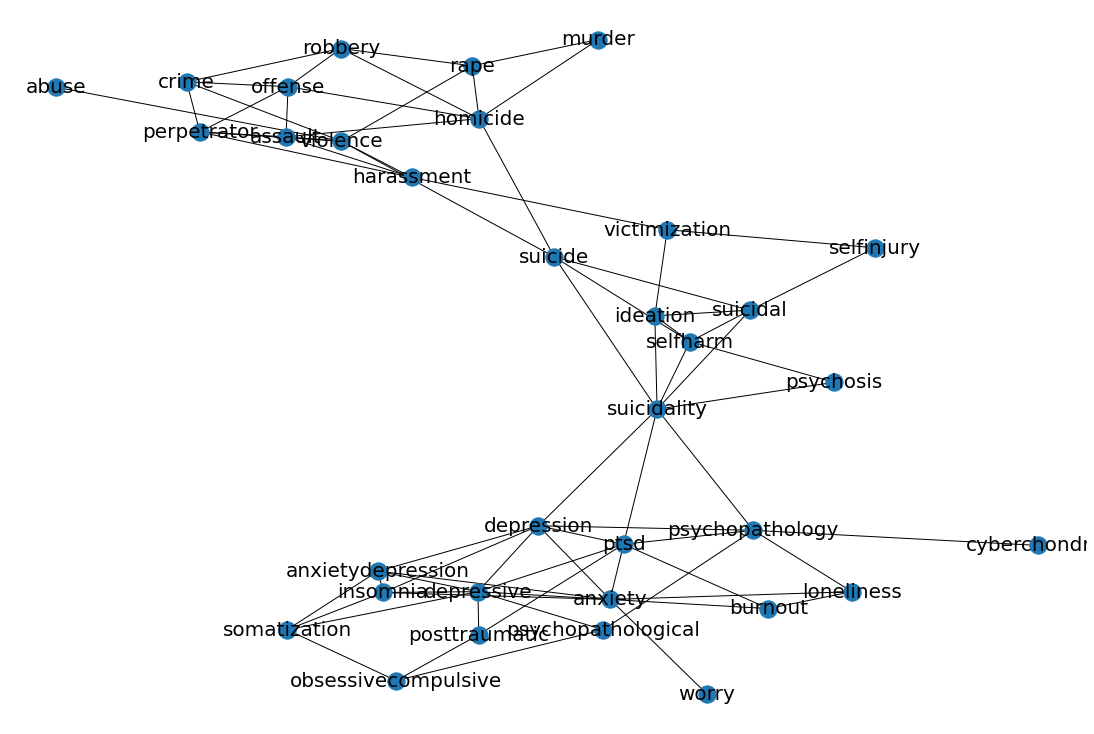

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'depression')
nx.draw(g.subgraph(subgraph), with_labels=True, font_size = 20)

### 2) immunity

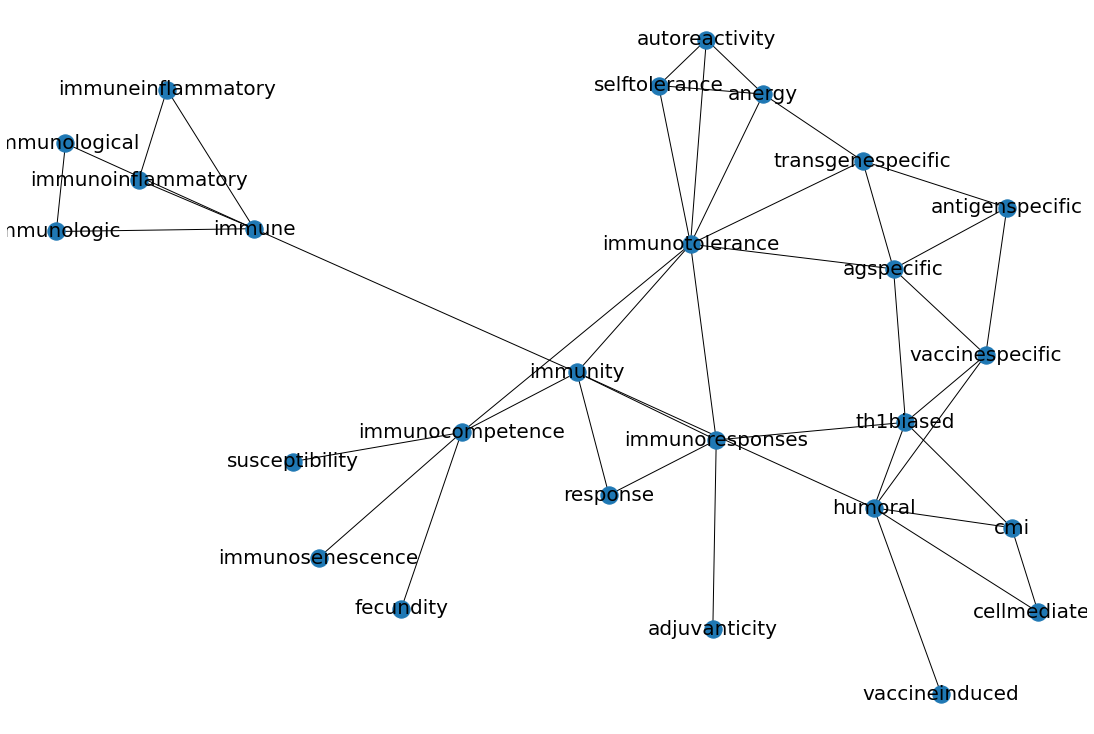

In [ ]:
plt.rcParams['figure.figsize'] = [15,10]
subgraph = nx.node_connected_component(f,'immunity')
nx.draw(g.subgraph(subgraph), with_labels=True,font_size = 20)

### 3) epidemic

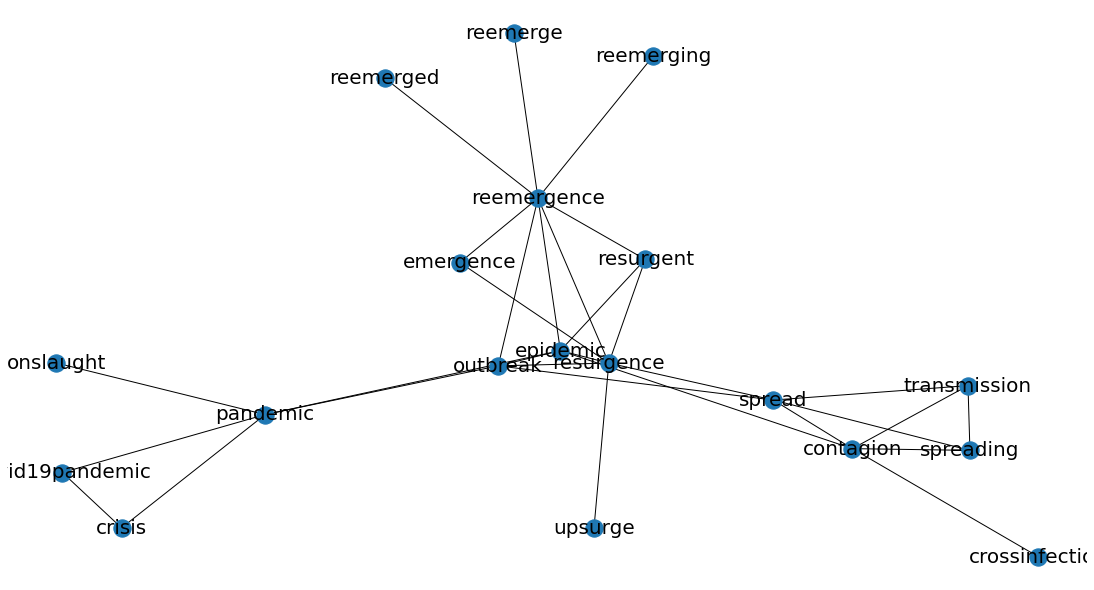

In [ ]:
plt.rcParams['figure.figsize'] = [15,8]
subgraph = nx.node_connected_component(f,'epidemic')
nx.draw(g.subgraph(subgraph), with_labels=True,font_size = 20)

### 4) suicide

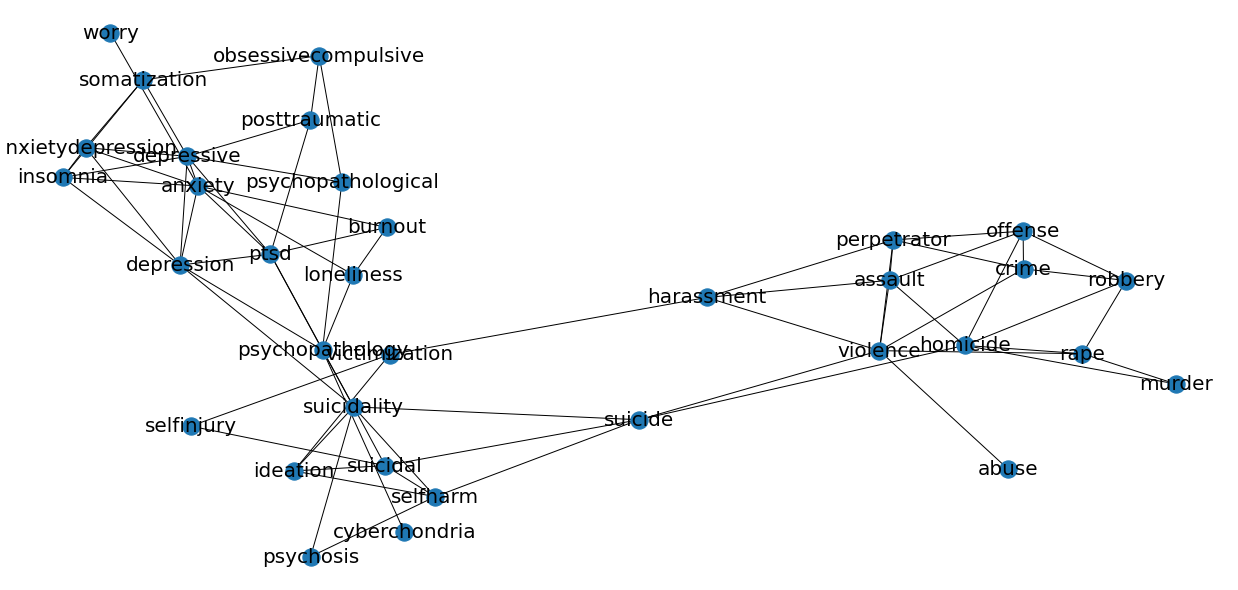

In [ ]:
plt.rcParams['figure.figsize'] = [17,8]
subgraph = nx.node_connected_component(f,'suicide')
nx.draw(g.subgraph(subgraph), with_labels=True,font_size = 20)

### 5) economy

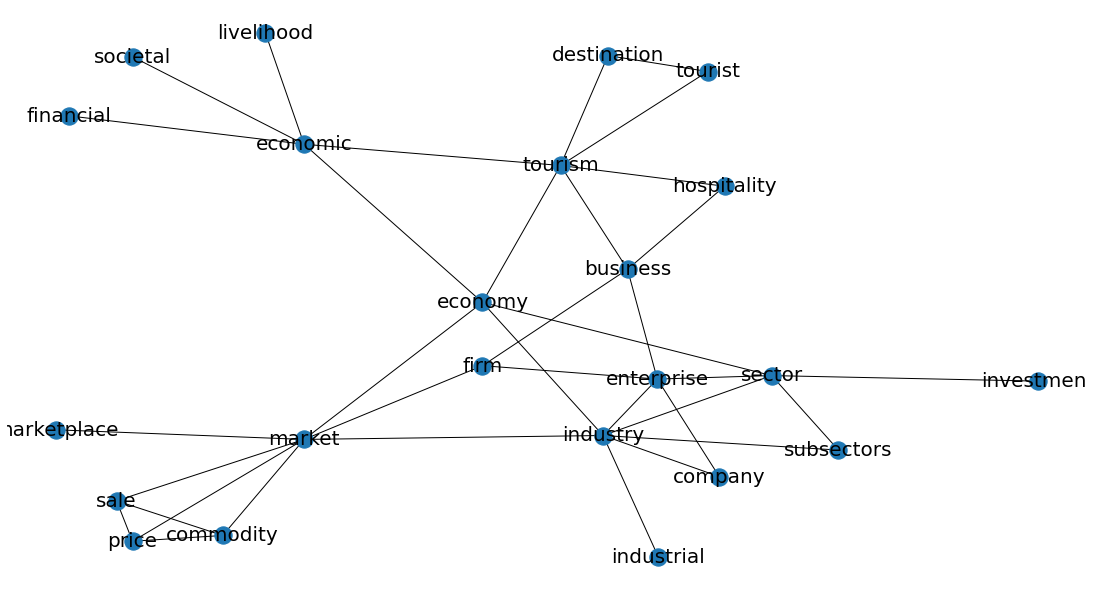

In [ ]:
plt.rcParams['figure.figsize'] = [15,8]
subgraph = nx.node_connected_component(f,'economy')
nx.draw(g.subgraph(subgraph), with_labels=True,font_size = 20)

### 6) bat

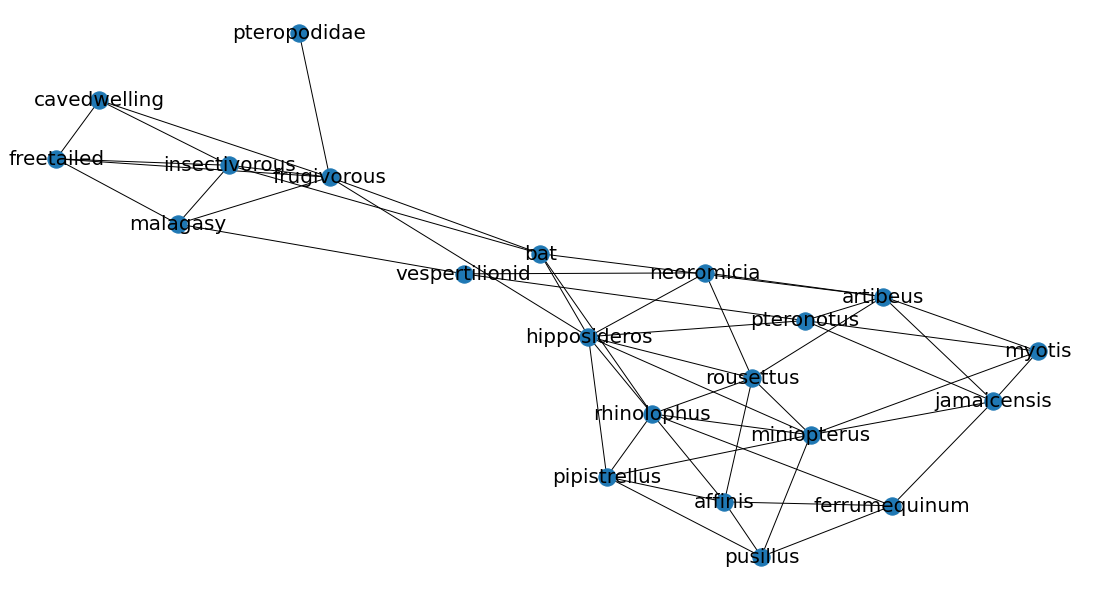

In [ ]:
plt.rcParams['figure.figsize'] = [15,8]
subgraph = nx.node_connected_component(f,'bat')
nx.draw(g.subgraph(subgraph), with_labels=True,font_size = 20)

### 7) pollution

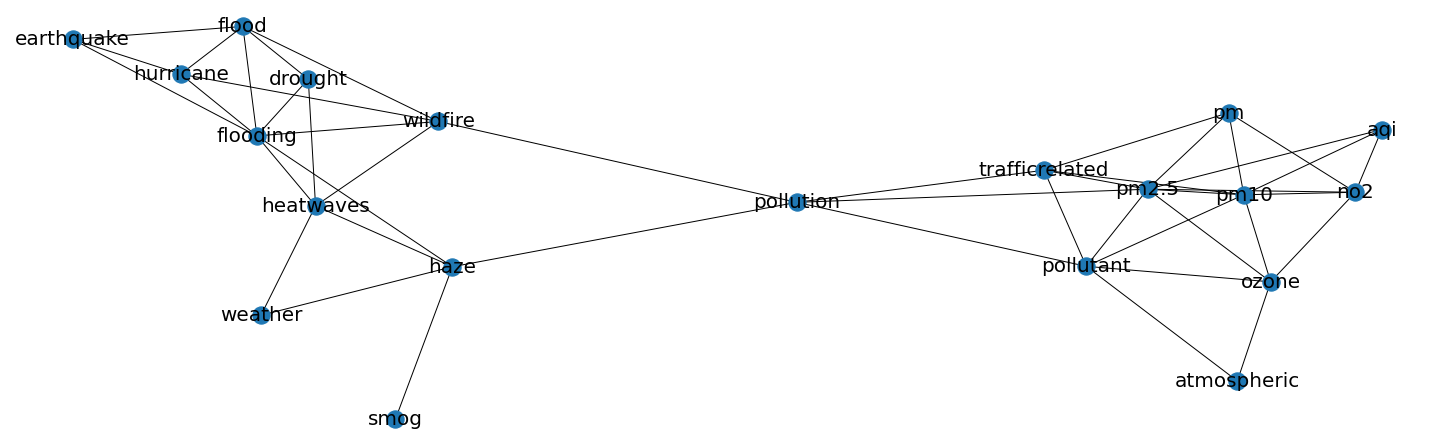

In [ ]:
plt.rcParams['figure.figsize'] = [20,6]
subgraph = nx.node_connected_component(f,'pollution')
nx.draw(g.subgraph(subgraph), with_labels=True,font_size = 20)

### 8) lockdown

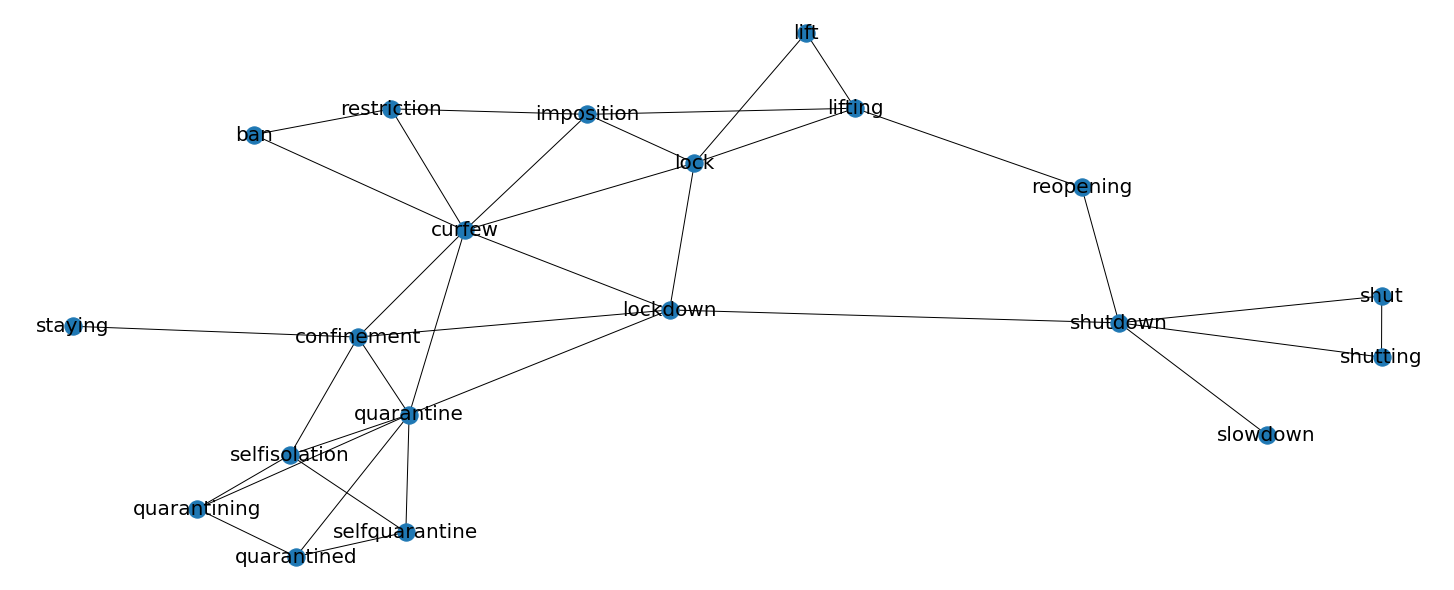

In [ ]:
plt.rcParams['figure.figsize'] = [20,8]
subgraph = nx.node_connected_component(f,'lockdown')
nx.draw(g.subgraph(subgraph), with_labels=True,font_size = 20)

### 9) healthcare

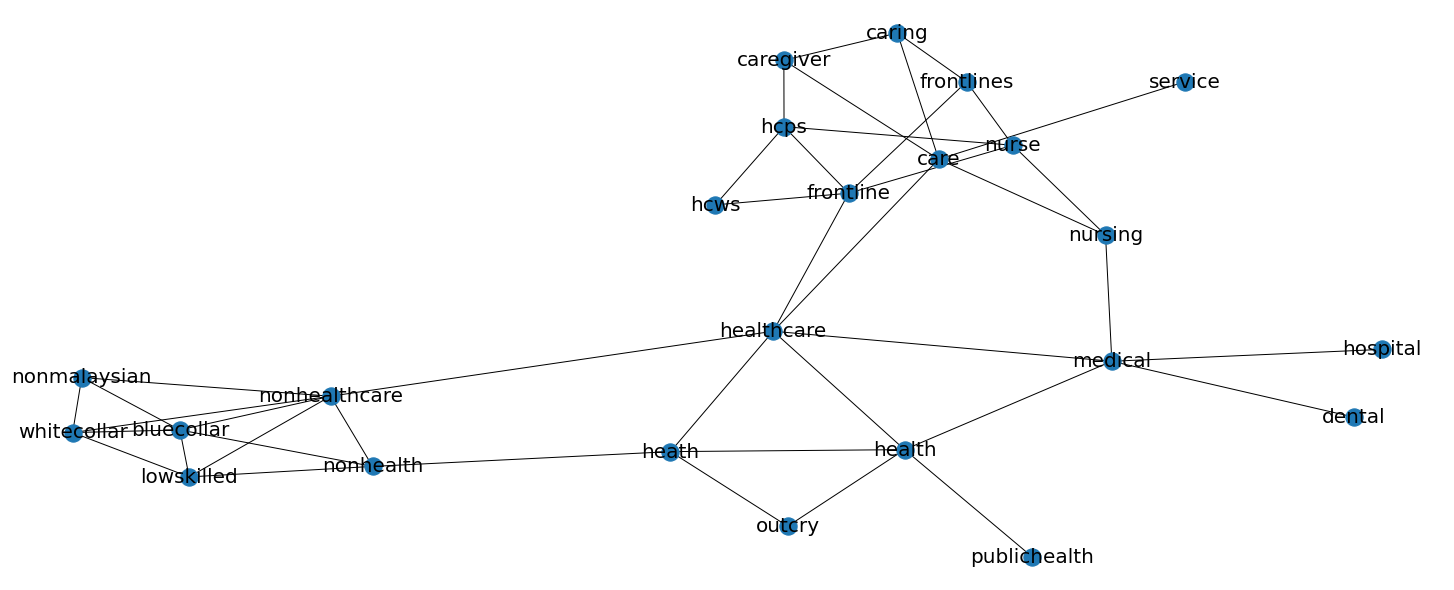

In [ ]:
plt.rcParams['figure.figsize'] = [20,8]
subgraph = nx.node_connected_component(f,'healthcare')
nx.draw(g.subgraph(subgraph), with_labels=True,font_size = 20)

### 10) twitter

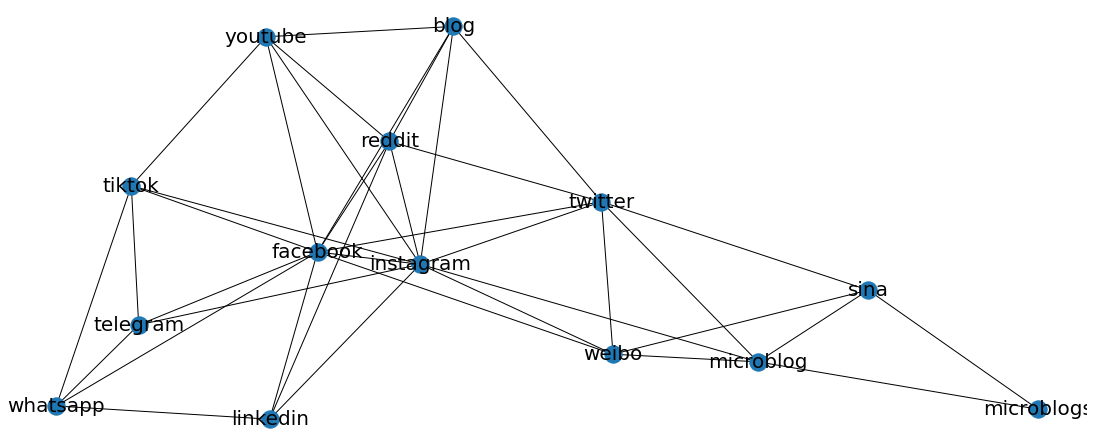

In [ ]:
plt.rcParams['figure.figsize'] = [15,6]
subgraph = nx.node_connected_component(f,'twitter')
nx.draw(g.subgraph(subgraph), with_labels=True,font_size = 20)

## Knowledge graph pdf link for all keywords 

[Knowledge Graph pdf link](https://drive.google.com/file/d/1-03KpxwXgGMjeOEc6xfPcDPJeh5LDCaf/view?usp=sharing)